In [139]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [653]:
from mini_yolov3.model import MiniYoloV3
from mini_yolov3.trainer import Trainer
import torch
from torchvision.transforms import v2
from mini_yolov3.dataset import SVHNDataset, collate_fn
from torch.utils.data import Subset, DataLoader
from mini_yolov3.loss import YOLOLoss, build_targets
import matplotlib.pyplot as plt
from mini_yolov3.utils import draw_bounding_boxes, count_model_parameters
from torchvision.ops import box_convert
from mini_yolov3.evals import calculate_mAP
from torchvision.ops import box_iou
from tqdm import tqdm

In [792]:
train_dataset = SVHNDataset(split="train", image_size=64)
# train_dataset = Subset(train_dataset, range(12, 13))

/Users/ericchen/Library/Caches/pypoetry/virtualenvs/mini-yolov3-a3VRlvzj-py3.10/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for svhn contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/svhn
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Using the latest cached version of the dataset since svhn couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'full_numbers' at /Users/ericchen/.cache/huggingface/datasets/svhn/full_numbers/1.0.0/87960e3ba96b1fe4963f1d7f1ad368dc2537bf94 (last modified on Sat Mar 30 11:03:58 2024).


In [657]:
train_dataset[0]["bbox"]

tensor([[0.3551, 0.0217, 0.1963, 0.8696],
        [0.5327, 0.0652, 0.1495, 0.8696]])

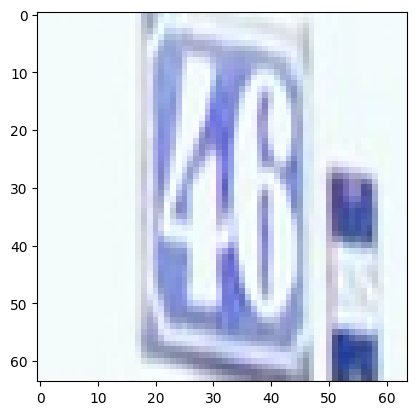

In [658]:
plt.imshow(train_dataset[0]["image"].permute(1, 2, 0))

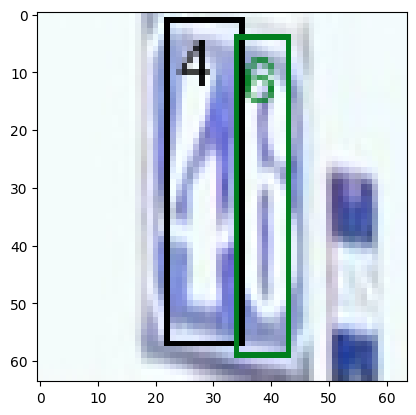

In [659]:
plt.imshow(
    draw_bounding_boxes(train_dataset[0]["image"], box_convert(train_dataset[0]["bbox"], "xywh", "xyxy"), train_dataset[0]["labels"])
)

In [843]:
train_dataset_ = Subset(train_dataset, range(0, 10))

In [844]:
import json

In [915]:
torch.manual_seed(0)

config = json.load(open("./configs/test.json", "r"))
model = MiniYoloV3(**config)

trainer = Trainer(
    model=model,
    train_dataset=train_dataset_,
    num_epochs=200,
    lr=5e-3,
    batch_size=32,
    lambda_coord=0.05,
    log_detections=False,
    lambda_conf=1.0,
    lambda_cls=0.5,
    device="cpu",
    eval_every=100000,
)

100%|██████████| 200/200 [00:31<00:00,  6.40it/s, class_loss=0.000398, conf_loss=0.000112, coord_loss=0, loss=0.00051] 


[1.451476812362671,
 1.2703309059143066,
 1.0530227422714233,
 1.102120041847229,
 0.9607826471328735,
 0.9311560988426208,
 0.841808557510376,
 0.7637982964515686,
 0.7333245277404785,
 0.6829673051834106,
 0.6199085712432861,
 0.59681236743927,
 0.5324450135231018,
 0.4971604645252228,
 0.4605829119682312,
 0.4154876470565796,
 0.38774818181991577,
 0.3496100604534149,
 0.31344592571258545,
 0.28663963079452515,
 0.260417103767395,
 0.2407722920179367,
 0.23028448224067688,
 0.22720298171043396,
 0.22078298032283783,
 0.20066982507705688,
 0.18479129672050476,
 0.18473751842975616,
 0.18070317804813385,
 0.17171813547611237,
 0.16402097046375275,
 0.1649760603904724,
 0.15325158834457397,
 0.15873335301876068,
 0.17917600274085999,
 0.192435622215271,
 0.16935253143310547,
 0.16905075311660767,
 0.15992148220539093,
 0.19396334886550903,
 0.36548906564712524,
 0.41051357984542847,
 0.5071876645088196,
 0.45974212884902954,
 0.3543011546134949,
 0.29700031876564026,
 0.263748258352279

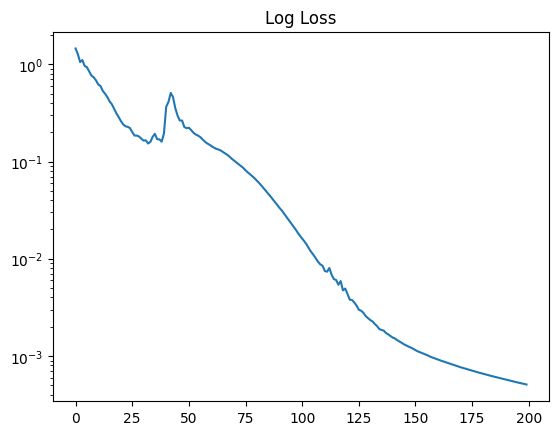

In [916]:
trainer.train()

In [918]:
count_model_parameters(model)

81783

In [919]:
dataloader = DataLoader(train_dataset_, batch_size=5, shuffle=False, collate_fn=collate_fn)
batch = next(iter(dataloader))

In [920]:
pred = model(batch["images"])
pred

[tensor([[[[ 2.3518e+00,  3.0028e+00,  3.5620e+00,  ...,  1.0266e+00,
             7.0866e+00, -1.2189e-02],
           [ 3.6279e+00,  4.9976e+00,  5.6541e+00,  ...,  1.0780e+00,
             1.1923e+01,  9.8030e-01],
           [ 4.7439e+00,  6.2064e+00,  6.7213e+00,  ...,  4.6751e-01,
             1.5305e+01,  2.6589e+00],
           ...,
           [ 4.2132e+00,  5.5878e+00,  6.4233e+00,  ...,  7.2685e-01,
             1.5010e+01,  1.4080e+00],
           [ 3.1479e+00,  4.1374e+00,  5.2936e+00,  ...,  7.1341e-01,
             1.1423e+01,  6.4897e-01],
           [ 1.6213e+00,  1.8523e+00,  3.1578e+00,  ...,  3.7571e-01,
             5.6233e+00,  1.0964e-01]],
 
          [[ 4.9826e+00,  4.8517e+00,  7.8332e+00,  ...,  2.3425e+00,
             1.4403e+01,  2.5669e+00],
           [ 8.0197e+00,  9.6382e+00,  1.1372e+01,  ...,  1.1634e+00,
             2.4371e+01,  6.0815e+00],
           [ 1.0871e+01,  1.4501e+01,  1.0364e+01,  ..., -4.6202e+00,
             3.3416e+01,  1.5210e+01],


In [921]:
batch

{'images': tensor([[[[0.9569, 0.9529, 0.9490,  ..., 0.9569, 0.9569, 0.9529],
           [0.9529, 0.9529, 0.9529,  ..., 0.9529, 0.9529, 0.9529],
           [0.9529, 0.9529, 0.9529,  ..., 0.9529, 0.9529, 0.9529],
           ...,
           [0.9529, 0.9569, 0.9529,  ..., 0.9451, 0.9490, 0.9529],
           [0.9608, 0.9608, 0.9608,  ..., 0.9451, 0.9490, 0.9529],
           [0.9647, 0.9608, 0.9647,  ..., 0.9451, 0.9529, 0.9569]],
 
          [[0.9922, 0.9882, 0.9843,  ..., 0.9882, 0.9882, 0.9843],
           [0.9882, 0.9882, 0.9882,  ..., 0.9843, 0.9843, 0.9843],
           [0.9882, 0.9882, 0.9882,  ..., 0.9843, 0.9843, 0.9843],
           ...,
           [0.9843, 0.9882, 0.9843,  ..., 0.9804, 0.9843, 0.9804],
           [0.9804, 0.9843, 0.9843,  ..., 0.9765, 0.9804, 0.9804],
           [0.9804, 0.9804, 0.9843,  ..., 0.9725, 0.9765, 0.9765]],
 
          [[0.9882, 0.9843, 0.9804,  ..., 0.9961, 0.9961, 0.9922],
           [0.9843, 0.9843, 0.9843,  ..., 0.9922, 0.9922, 0.9922],
           [0.

In [922]:
i = 0

In [923]:
output = model.inference(
    batch["images"],
    confidence_threshold=0.5,
)

bounding_boxes = output.bboxes
bounding_boxes

[{'bboxes': tensor([[4.9981e-01, 5.0000e-01, 2.3692e-05, 1.6779e+01],
          [3.7694e-01, 6.2500e-01, 2.6355e-04, 1.3642e+03],
          [5.0597e-01, 6.2500e-01, 1.2220e-11, 1.0128e+03],
          [6.2500e-01, 5.0000e-01, 9.9027e-08, 4.0440e+00],
          [3.6442e-01, 5.0000e-01, 3.4732e+02, 2.7853e+02]]),
  'confidence': tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9991]),
  'labels': tensor([2, 5, 6, 9, 7]),
  'scores': tensor([0.9802, 0.6585, 1.0000, 0.9999, 0.9814])},
 {'bboxes': tensor([[6.2499e-01, 6.2500e-01, 2.9187e-02, 2.0243e+05],
          [4.9953e-01, 6.2500e-01, 2.8024e+02, 7.9805e+03]]),
  'confidence': tensor([1.0000, 0.9998]),
  'labels': tensor([1, 7]),
  'scores': tensor([1.0000, 0.6793])},
 {'bboxes': tensor([[4.4999e-01, 6.2500e-01, 3.8932e-03, 7.8673e-02],
          [6.0999e-01, 6.2500e-01, 5.9996e-06, 1.9136e-02]]),
  'confidence': tensor([1.0000, 0.9989]),
  'labels': tensor([3, 9]),
  'scores': tensor([0.9947, 0.5546])},
 {'bboxes': tensor([[3.7684e-01, 6.2500e

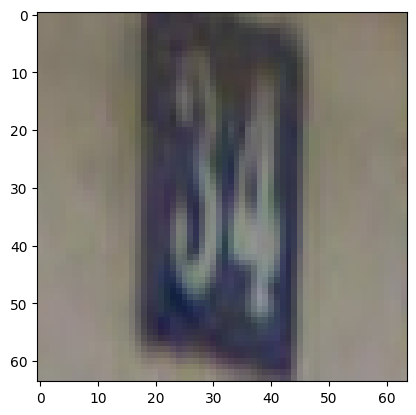

In [903]:
plt.imshow(
    draw_bounding_boxes(batch["images"][i],
                        box_convert(
                            bounding_boxes[i]["bboxes"], 
                            "cxcywh",
                            "xyxy"
                        ), 
                        bounding_boxes[i]["labels"]
)
)

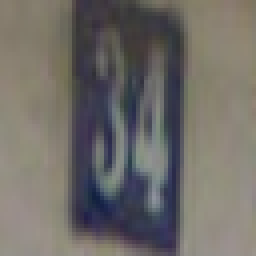

In [904]:
draw_bounding_boxes(batch["images"][i],
                        box_convert(
                            bounding_boxes[i]["bboxes"], 
                            "cxcywh",
                            "xyxy"
                        ), 
                        bounding_boxes[i]["labels"]
).resize((256, 256), 0)

In [823]:
calculate_mAP(
    model,
    trainer.train_loader,
)

{'map': 0.0,
 'map_50': 0.0,
 'map_75': 0.0,
 'map_small': 0.0,
 'map_medium': -1.0,
 'map_large': -1.0,
 'mar_1': 0.0,
 'mar_10': 0.0,
 'mar_100': 0.0,
 'mar_small': 0.0,
 'mar_medium': -1.0,
 'mar_large': -1.0,
 'map_per_class': -1.0,
 'mar_100_per_class': -1.0,
 'classes': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

In [325]:
torch.distributed.is_available()

True